## Requirements

In [ ]:
! pip install beautifulsoup4 lxml matplotlib

In [ ]:
! pip install git+https://github.com/cmd-ntrf/pytesseract

## Initialization

In [1]:
import pyspark
sc = pyspark.SparkContext()

In [2]:
! ls /project/datasets/TimesOCR/TDA_GDA_1785-2007/1860

18600102  18600216  18600402  18600517	18600702  18600816  18601001  18601117
18600103  18600217  18600403  18600518	18600703  18600817  18601002  18601119
18600104  18600218  18600404  18600519	18600704  18600818  18601003  18601120
18600105  18600220  18600405  18600521	18600705  18600820  18601004  18601121
18600106  18600221  18600406  18600522	18600706  18600821  18601005  18601122
18600107  18600222  18600407  18600523	18600707  18600822  18601006  18601123
18600109  18600223  18600409  18600524	18600709  18600823  18601008  18601124
18600110  18600224  18600410  18600525	18600710  18600824  18601009  18601126
18600111  18600225  18600411  18600526	18600711  18600825  18601010  18601127
18600112  18600227  18600412  18600528	18600712  18600827  18601011  18601128
18600113  18600228  18600413  18600529	18600713  18600828  18601012  18601129
18600114  18600229  18600414  18600530	18600714  18600829  18601013  18601130
18600116  18600301  18600416  18600531	18600716  18600830  18601

In [3]:
xmlfiles = sc.wholeTextFiles('/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/1860*/*.xml',64)

In [4]:
print(xmlfiles.getNumPartitions())

59


In [5]:
print(xmlfiles.count())

310


## Prepping on small data

In [6]:
first_xml_file = xmlfiles.first()

In [7]:
filename = first_xml_file[0]
newspaper_text = first_xml_file[1]
print(filename)
print(newspaper_text[:500])

file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600427/0FFO-1860-APR27.xml
<?xml version="1.0" encoding="ISO-8859-1"?>
<!DOCTYPE issue SYSTEM "LTO_issue.dtd">
<issue>
<id>0FFO-1860-APR27</id>
<jn>The Times</jn>
<ba>0FFO</ba>
<is>23605</is>
<da>April 27, 1860</da>
<pf>18600427</pf>
<ip>16</ip>
<cp>Copyright 1860, The Times</cp>
<article>
<id>0FFO-1860-APR27-001-001</id>
<ocr relevant="yes">50.89</ocr>
<sc>a</sc>
<pi pgref="1">0FFO-1860-APR27-001</pi>
<ci pgref="1" clip="1">0FFO-1860-APR27-001-001-001</ci>
<pa>1</pa>
<pc>1</pc>
<ti>Births</ti>
<ct>Bir


In [12]:
searchterm="Canada"

In [13]:
def simple_process_day(fstring):
    return fstring.count(searchterm)

In [14]:
def newsonly_process_day(fstring):
    inside_news = False
    count = 0
    for line in fstring.split("\n"):
        if "<ct>News</ct>" in line:
            inside_news = True
        if "</article>" in line:
            inside_news = False
        if inside_news:
            count += line.count(searchterm)
    return count

In [15]:
print("output", newsonly_process_day(newspaper_text))

output 1


In [16]:
import lxml
from bs4 import BeautifulSoup

In [17]:
document = BeautifulSoup(newspaper_text, "lxml")

In [19]:
articles = document.find_all('article')

In [35]:
articles[9].find('ct')

<ct>News</ct>

In [36]:
news_article = articles[9]

In [44]:
news_article.find('text.cr').find_all('wd')[0]

<wd pos="1624,4820,1788,4853">13BRouGss</wd>

In [54]:
news_article.find('text.cr').find_all('wd')[0].attrs

{'pos': '1624,4820,1788,4853'}

In [ ]:
"<a href='https://www.google.com'>Google</a>"

In [57]:
"Oh Canada Canada Canada".count("Canada")

3

In [58]:
def bs4_process_day(fstring):
    soup = BeautifulSoup(fstring, "lxml")
    count = 0
    taglist = soup.find_all("article")
    for tag in taglist:
        ct_tag = tag.find("ct")
        if ct_tag.string == "News":
            articletext = tag.find("text.cr")
            words = articletext.find_all("wd")
            for w in words:
                count += w.string == 'Canada'
    return count

In [59]:
print("output", bs4_process_day(newspaper_text))

output 1


In [60]:
canada_counts = xmlfiles.mapValues(lambda document: bs4_process_day(document)).cache()

In [65]:
canada_counts.take(10)

[('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600427/0FFO-1860-APR27.xml',
  1),
 ('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600324/0FFO-1860-MAR24.xml',
  0),
 ('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600705/0FFO-1860-JUL05.xml',
  2),
 ('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600612/0FFO-1860-JUN12.xml',
  0),
 ('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18601127/0FFO-1860-NOV27.xml',
  0),
 ('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600706/0FFO-1860-JUL06.xml',
  0),
 ('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600421/0FFO-1860-APR21.xml',
  0),
 ('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18601008/0FFO-1860-OCT08.xml',
  0),
 ('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18601229/0FFO-1860-DEC29.xml',
  2),
 ('file:/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600511/0FFO-1860-MAY11.xml',
  0)]

In [71]:
'/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600511/0FFO-1860-MAY11.xml'.split('/')[-2]

'18600511'

In [72]:
canada_counts_withdates = canada_counts.map(lambda pair: (pair[0].split('/')[-2], pair[1]))

In [73]:
canada_counts_withdates.first()

('18600427', 1)

In [74]:
dates = canada_counts_withdates.collect()

In [75]:
import datetime

dd = datetime.date(1860,3,2)
print(dd)

1860-03-02


In [79]:
sorted(dates)[:10]

[('18600102', 2),
 ('18600103', 0),
 ('18600104', 0),
 ('18600105', 1),
 ('18600106', 1),
 ('18600107', 0),
 ('18600109', 0),
 ('18600110', 1),
 ('18600111', 0),
 ('18600112', 1)]

In [81]:
python_dates=[]
for d in dates:
    date_in_datetime = datetime.date(int(d[0][0:4]),int(d[0][4:6]),int(d[0][6:8]))
    python_dates.append((date_in_datetime,d[1]))

In [82]:
%matplotlib inline

/dev/shm/user10/venv/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


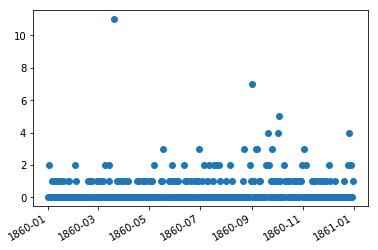

In [83]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.dates import drange
from numpy import zeros

date1 = datetime.datetime(1860,1,1)
date2 = datetime.datetime(1861,1,1)
delta = datetime.timedelta(days=1)
dates = drange(date1,date2,delta)
data=zeros(len(dates))

# fill in the data

for ele in python_dates:
    data[ele[0].toordinal()-date1.toordinal()]=ele[1]
    
fig, ax = matplotlib.pyplot.subplots()

ax.plot_date(dates,data)

fig.autofmt_xdate()

plt.show()


# Heat Map

In [86]:
f=open("/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/18600102/0FFO-1860-JAN02.xml",encoding="iso-8859-1")
newspaper_text=f.read()
f.close()

In [172]:
import re
pos_regex = re.compile(r"<wd pos=\"(\d+,\d+,\d+,\d+)\">")
# search_regex = re.compile(r"\b[tT][iI]r[mM][eE][sS]\b")
search_regex = re.compile(r"\b[wW][aA][rR]\b")
def process_newspaper(whole_newspaper):
    list_of_lines = whole_newspaper.split("\n")
    list_positions = []
    for line in list_of_lines:
        if len(re.findall(search_regex, line)) > 0:
            m = re.search(pos_regex, line)
            if m != None:
                list_positions.append(m.group(1))
    return list_positions

In [173]:
line = "Warren is at War in a warzone"

In [174]:
print(process_newspaper(newspaper_text))

['847,3309,913,3335', '2804,4599,2866,4625', '1735,4696,1870,4727', '489,3604,627,3639', '4487,2338,4546,2362', '343,4298,483,4329', '562,4341,720,4371', '943,2204,1069,2241', '1555,3464,1614,3492', '3773,4360,3846,4396', '3808,4415,3879,4452', '68,4513,152,4551', '594,5304,699,5342', '185,5332,269,5370', '1373,1784,1455,1820', '1522,2579,1609,2616', '2106,3200,2187,3238', '4684,2703,4774,2743', '4247,5917,4318,5946', '272,1501,359,1539', '652,2397,736,2435', '382,3291,469,3331', '3856,4009,3929,4042', '4413,4831,4506,4865', '209,3083,282,3114', '539,3347,642,3386', '1341,1347,1423,1382', '914,1513,1000,1548', '845,2007,919,2042', '1398,5423,1472,5457', '2583,3980,2672,4018', '3258,5716,3336,5755', '835,5099,914,5132', '1788,3326,1862,3360', '726,3837,824,3874', '1889,3941,1961,3979', '1842,2870,1916,2900', '3094,2632,3227,2670', '604,1178,687,1205']


In [175]:
# xmlfiles=sc.wholeTextFiles('/project/datasets/TimesOCR/TDA_GDA_1785-2007/1860/1860*/*.xml',64)
xmlfiles=sc.wholeTextFiles('/project/datasets/PageScans/1916/1916*/*.xml',64)
print(xmlfiles.count())

312


In [184]:
position_rdd = xmlfiles.flatMap(lambda pair: process_newspaper(pair[1]))
position_rdd_int = position_rdd.map(lambda string: tuple(map(int, string.split(","))))

In [194]:
from operator import add
position_freq_rdd = position_rdd_int.map(lambda pos: (pos, 1)).reduceByKey(add)

In [195]:
position_freq = position_freq_rdd.collect()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
frontPage = np.zeros((7000,5250))
frontPage = frontPage.astype('uint32')

for (pos, count) in position_freq:
    frontPage[pos[1]:pos[3], pos[0]:pos[2]] += count
    

plt.figure(figsize=(200,200))
image = plt.imshow(frontPage)
plt.show()